#### Modelo XGBoost

In [31]:
# Bibliotecas principais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import seaborn as sns

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [2]:
# carregando o dataset
df_mkt = pd.read_csv('../Data/Projetos_para_Treinamento.csv')

In [3]:
df_mkt.head(1)

,projeto,produto,tipo,tema,clima,investimento,alcance,engajamento,sentimento,edicao_repetida,resultado_anterior,inovacao,sucesso
0,Carnaval 2024,CARNA2024,Evento,Festivo,ensolarado,40000.0,15000.0,20000.0,neutro,Sim,bom,2.0,Sim


In [4]:
df_mkt.shape

(150, 13)

In [5]:
df_mkt.dtypes

projeto                object
produto                object
tipo                   object
tema                   object
clima                  object
investimento          float64
alcance               float64
engajamento           float64
sentimento             object
edicao_repetida        object
resultado_anterior     object
inovacao              float64
sucesso                object
dtype: object

In [6]:
df_mkt.isnull().sum()

projeto               0
produto               0
tipo                  0
tema                  0
clima                 0
investimento          0
alcance               0
engajamento           0
sentimento            0
edicao_repetida       0
resultado_anterior    0
inovacao              0
sucesso               0
dtype: int64

In [7]:
# Verificar duplicatas no df_train
duplicados = df_mkt.duplicated()

# Contar quantas linhas duplicadas existem (exceto a primeira ocorrência)
num_duplicados = duplicados.sum()

print(f"Número de linhas duplicadas: {num_duplicados}")

Número de linhas duplicadas: 0


In [8]:
# Quantidade de dados distribuidos
print(df_mkt.columns)

Index(['projeto', 'produto', 'tipo', 'tema', 'clima', 'investimento',
       'alcance', 'engajamento', 'sentimento', 'edicao_repetida',
       'resultado_anterior', 'inovacao', 'sucesso'],
      dtype='object')


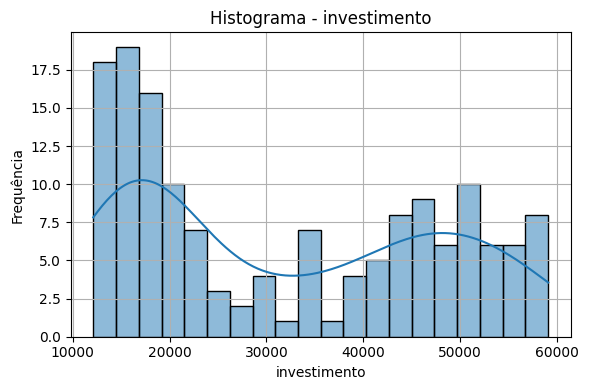

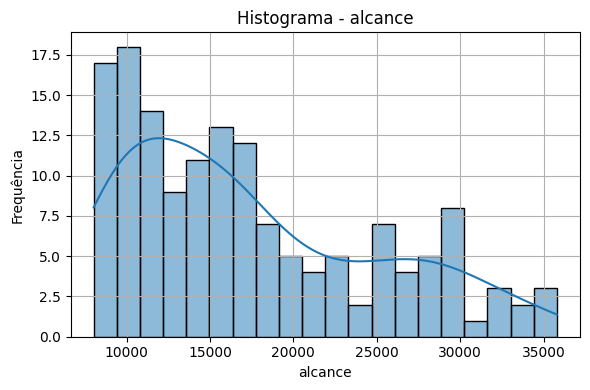

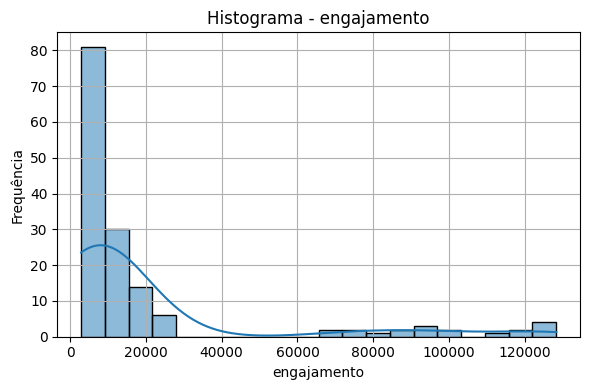

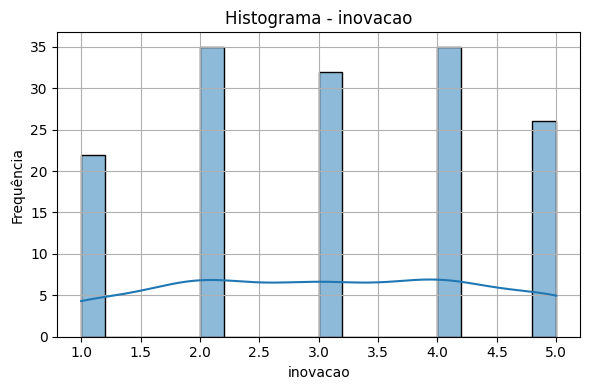

In [9]:
# Separar colunas numéricas e categóricas
num_cols = df_mkt.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df_mkt.select_dtypes(include=['object', 'category', 'bool']).columns

# Plotar histogramas para variáveis numéricas
for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df_mkt[col], kde=True, bins=20)
    plt.title(f'Histograma - {col}')
    plt.xlabel(col)
    plt.ylabel('Frequência')
    plt.grid(True)
    plt.tight_layout()
    plt.show()



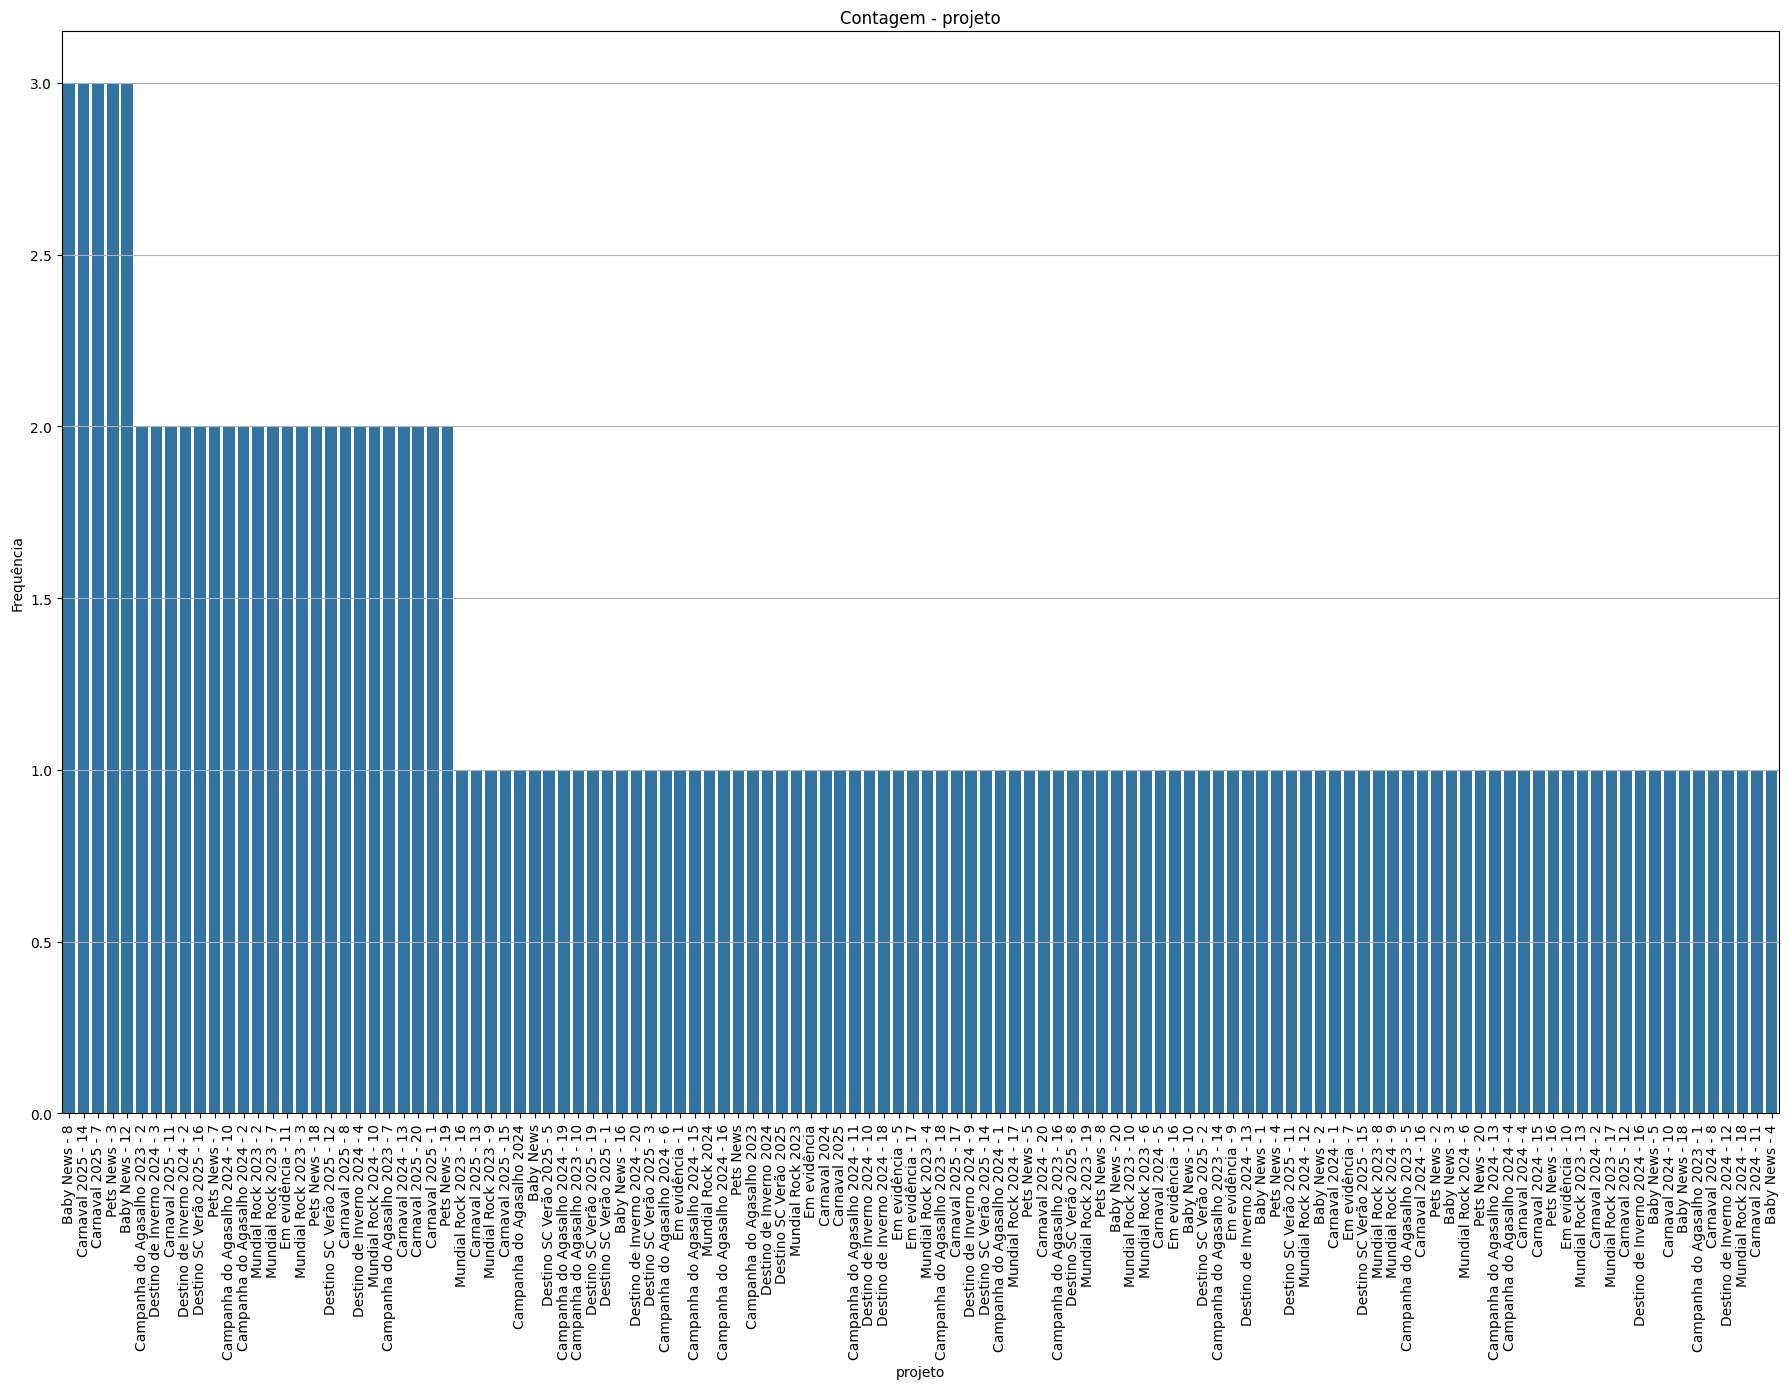

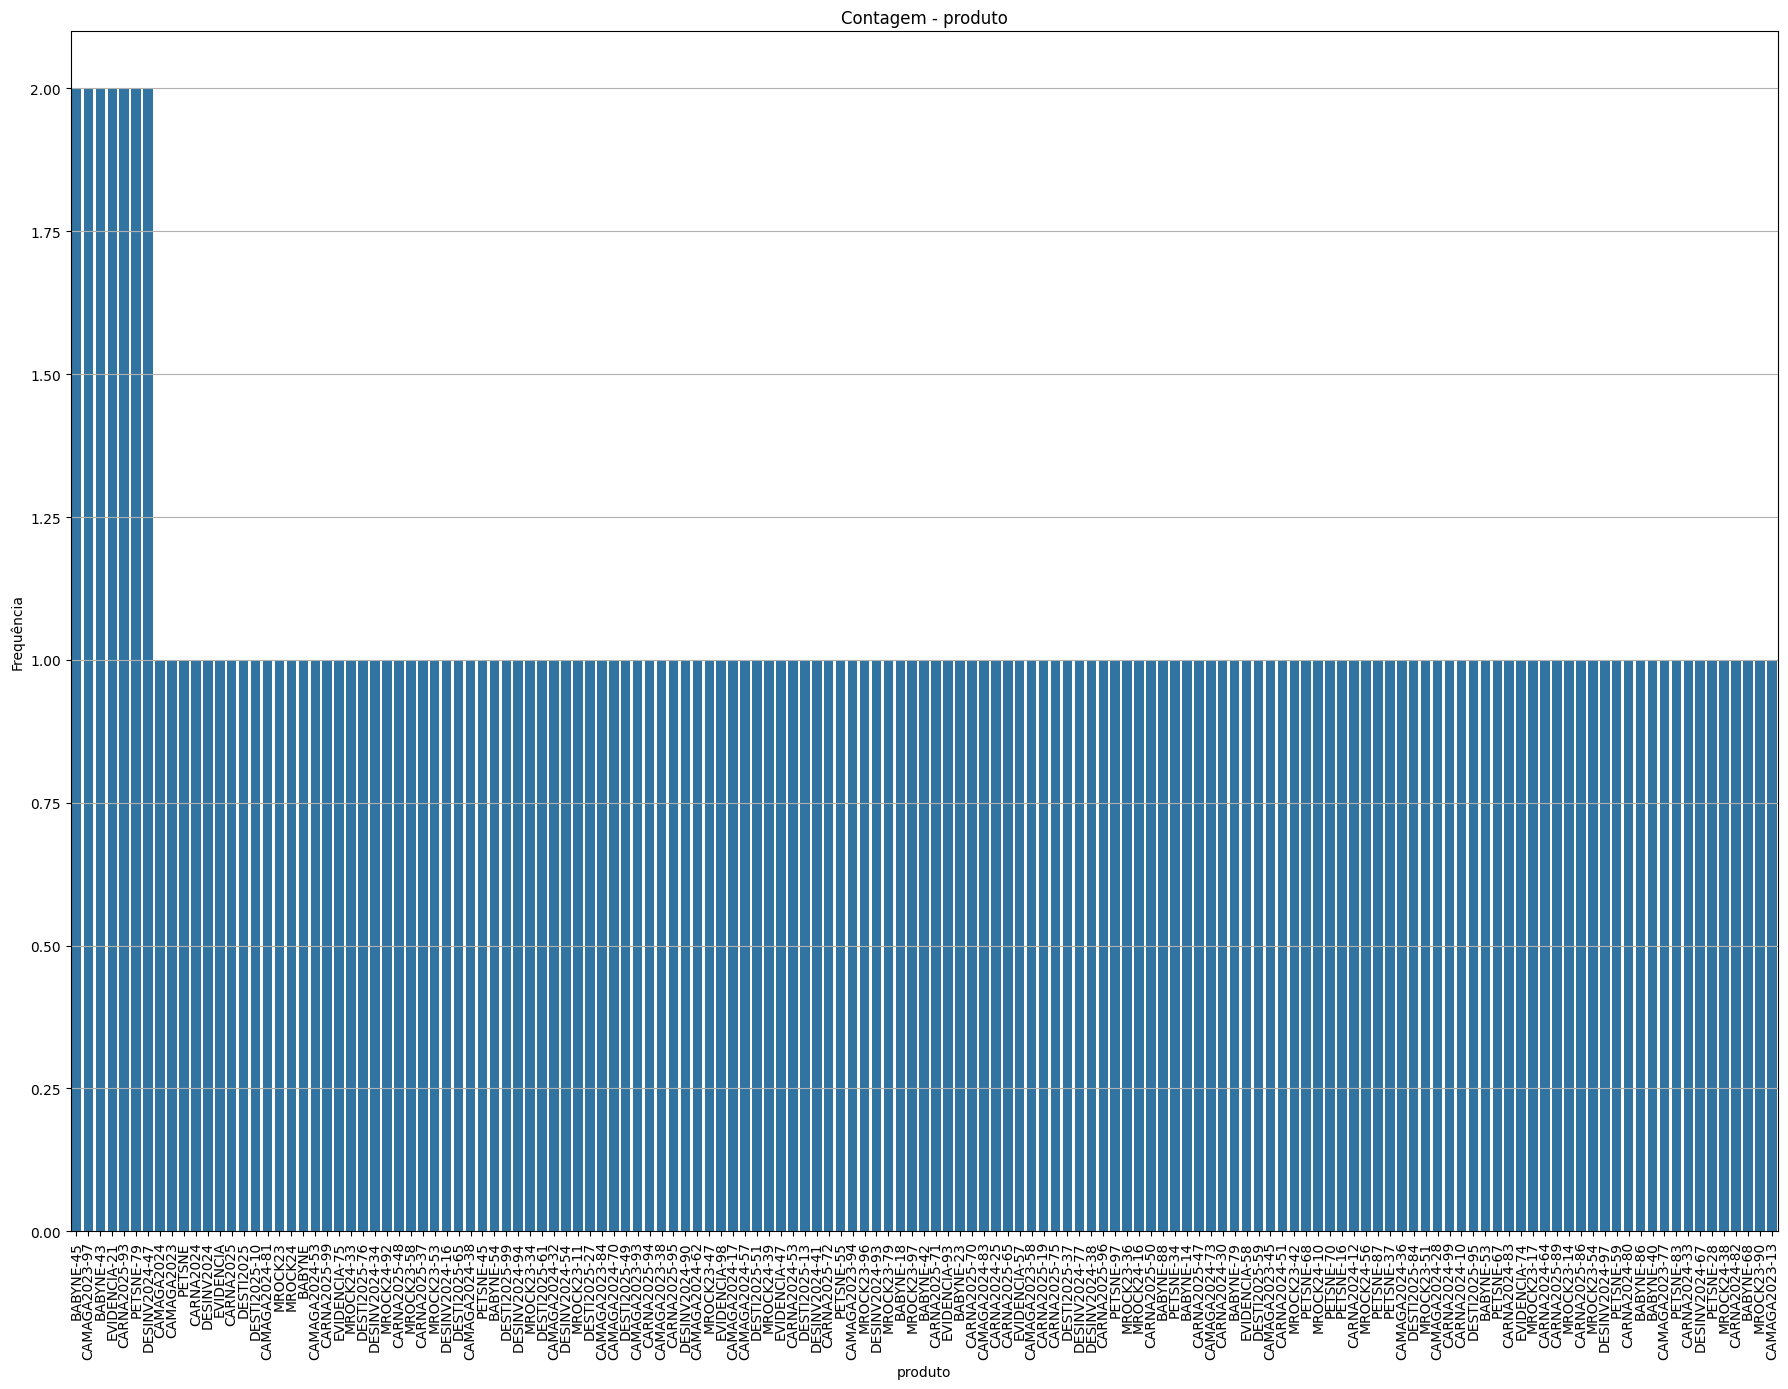

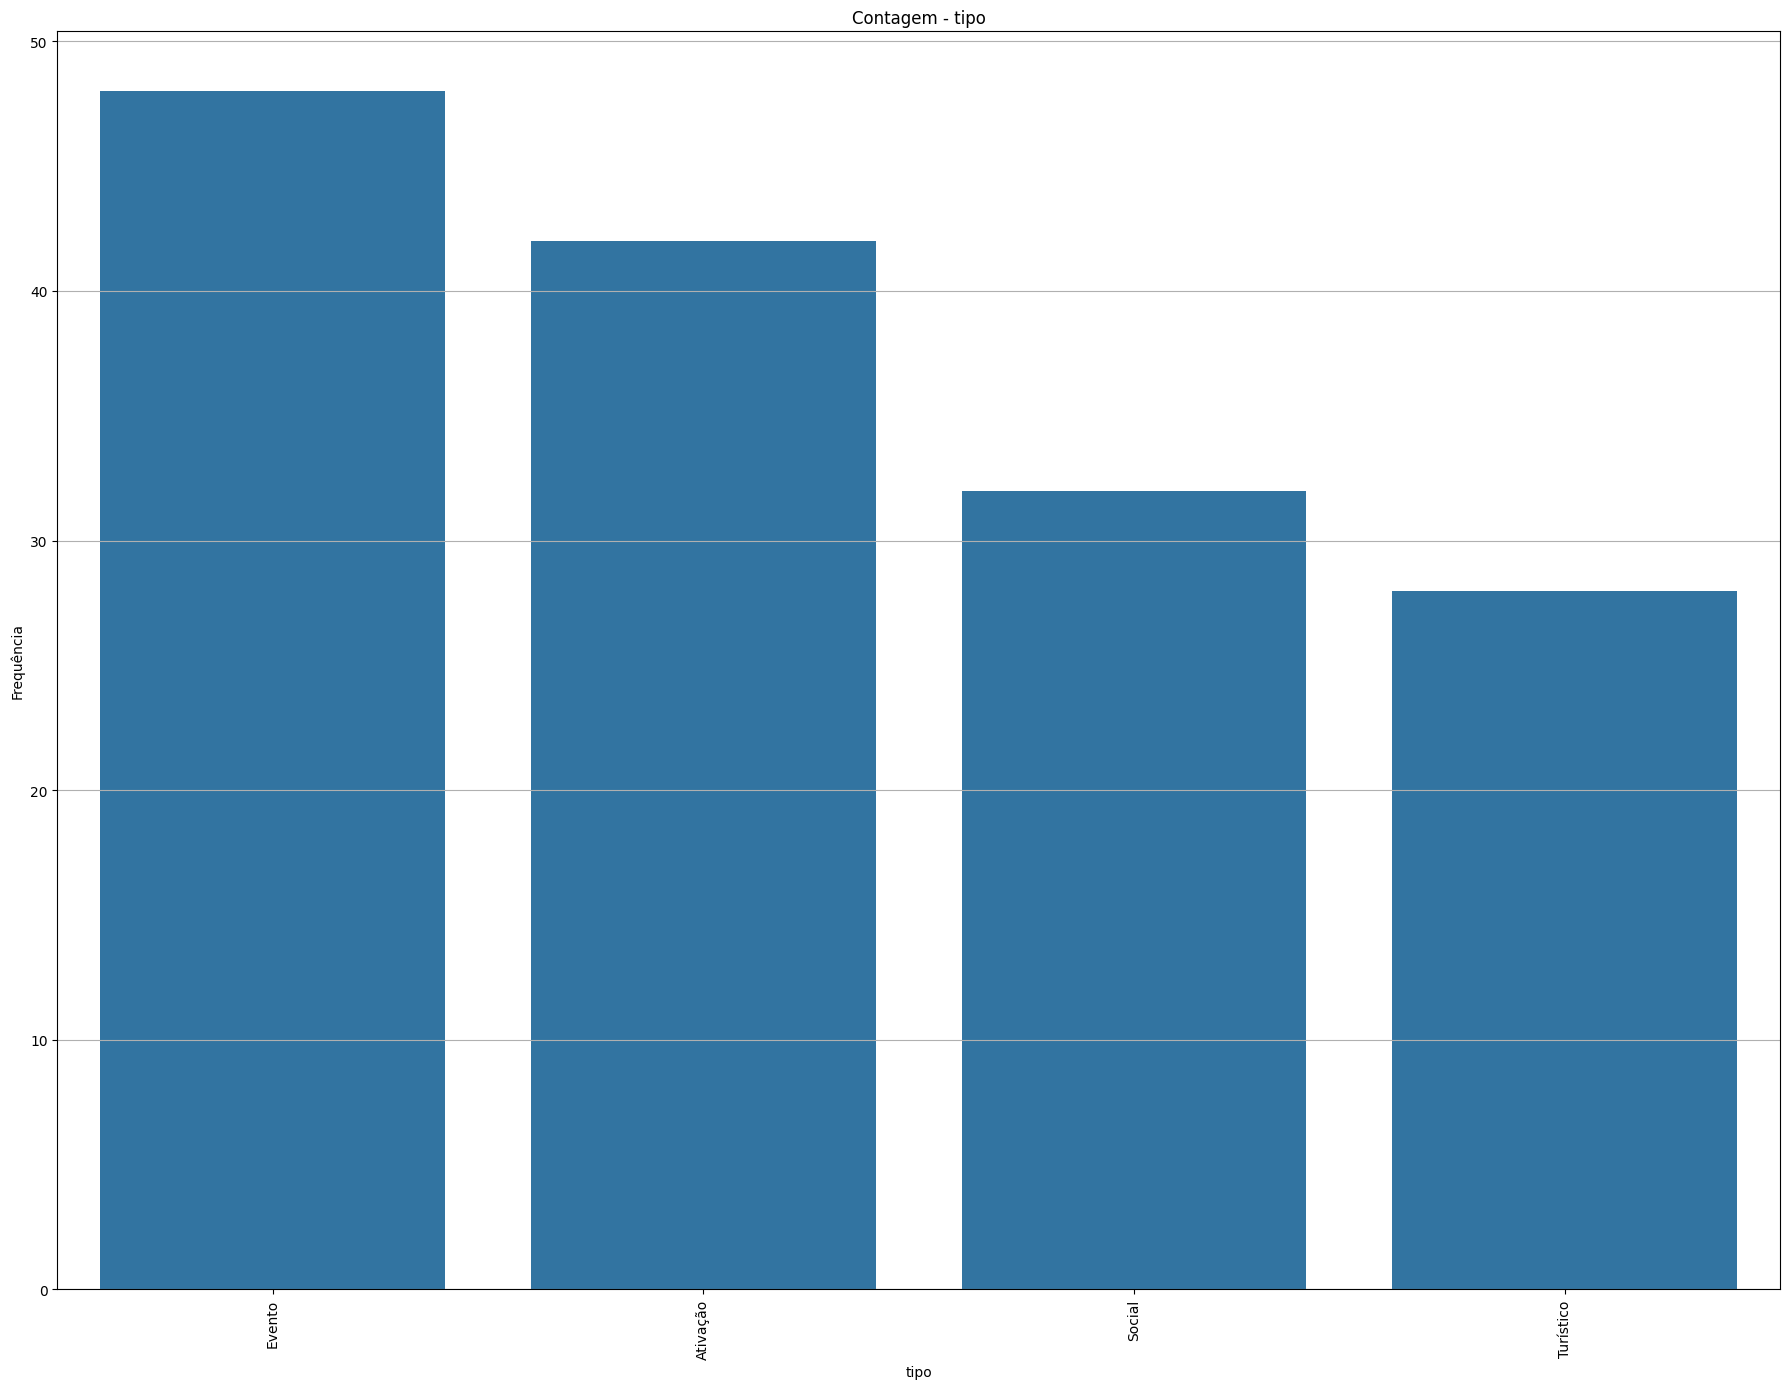

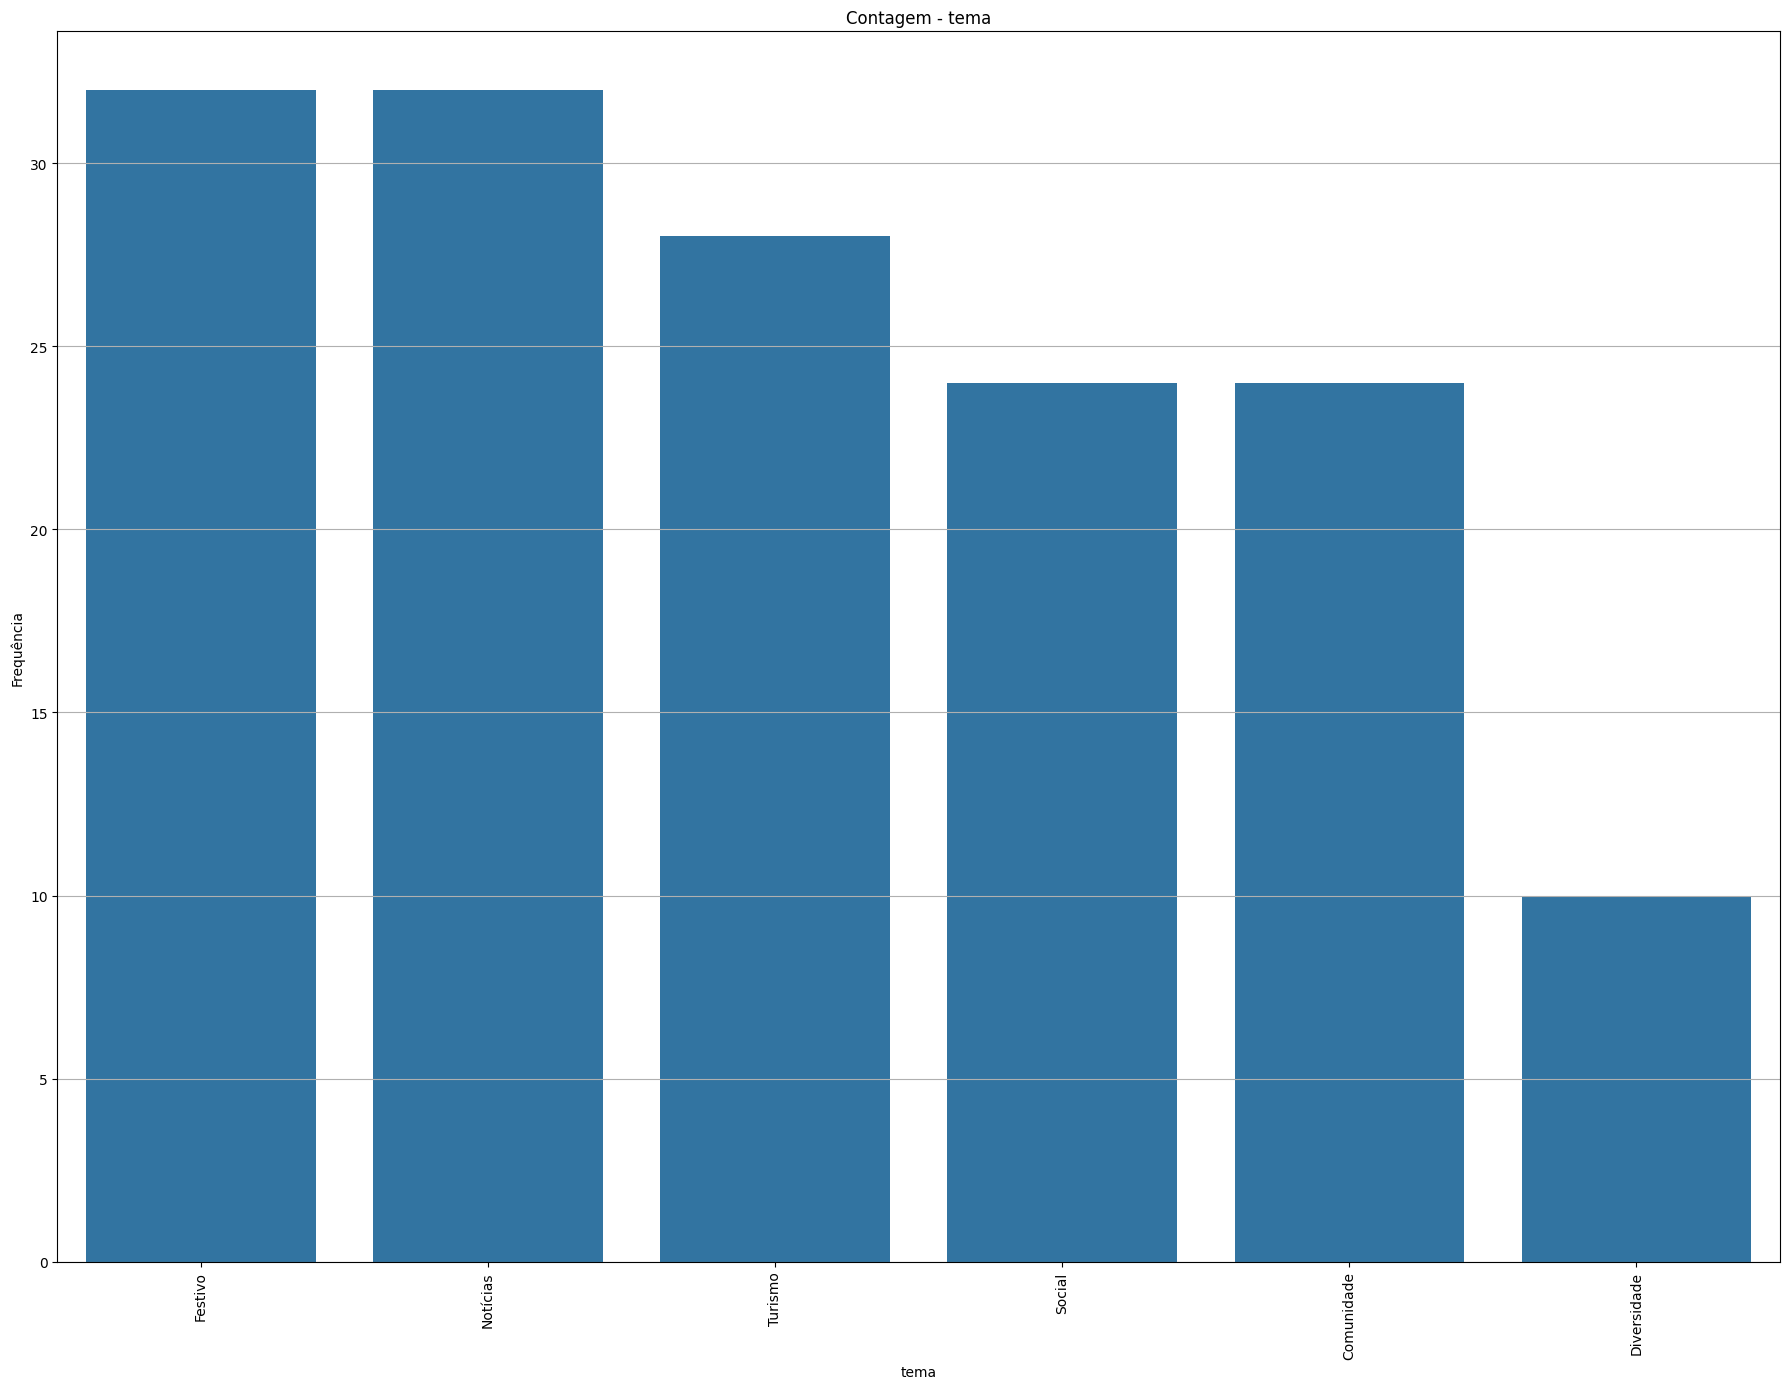

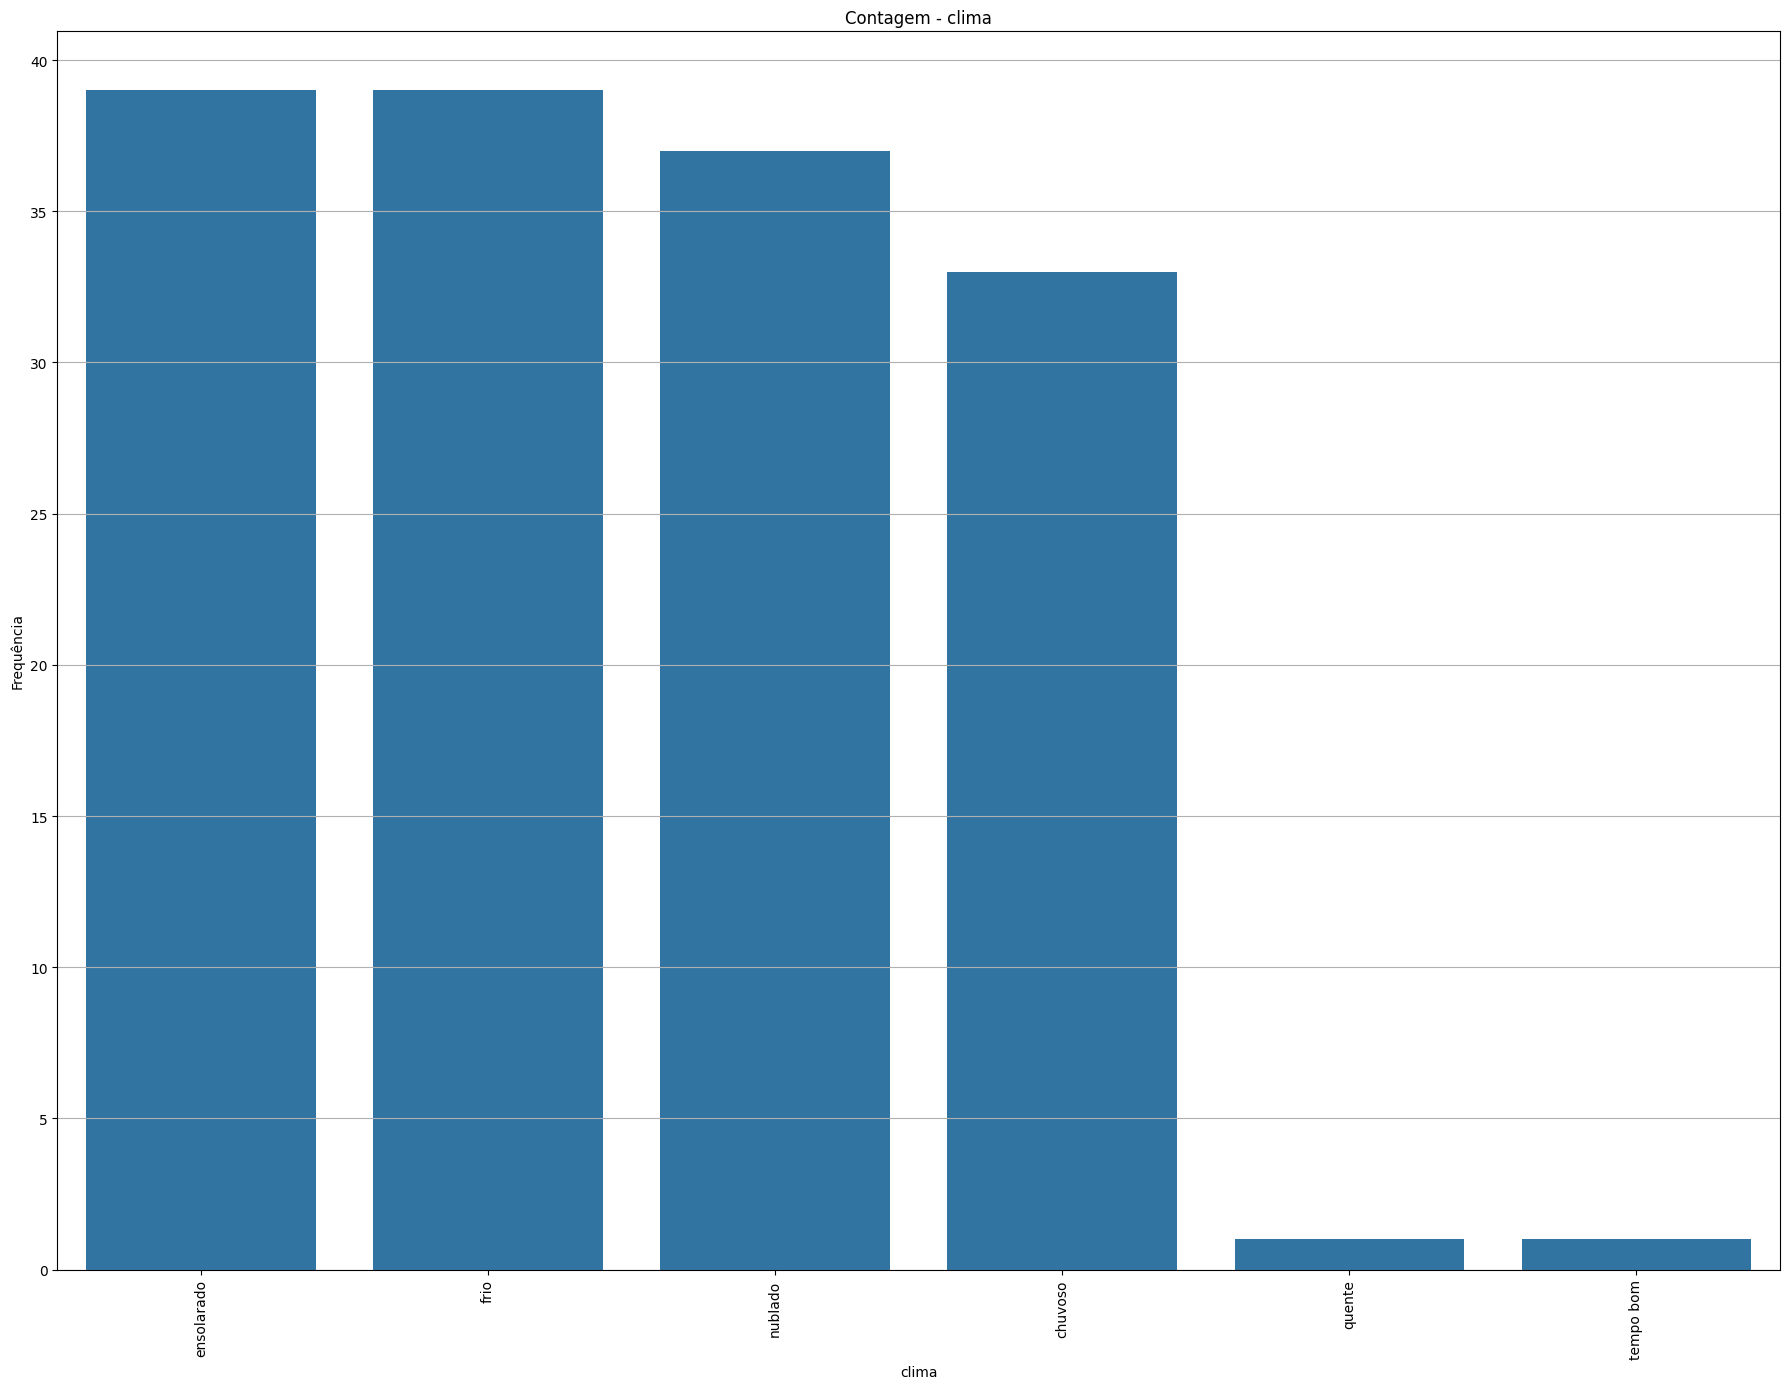

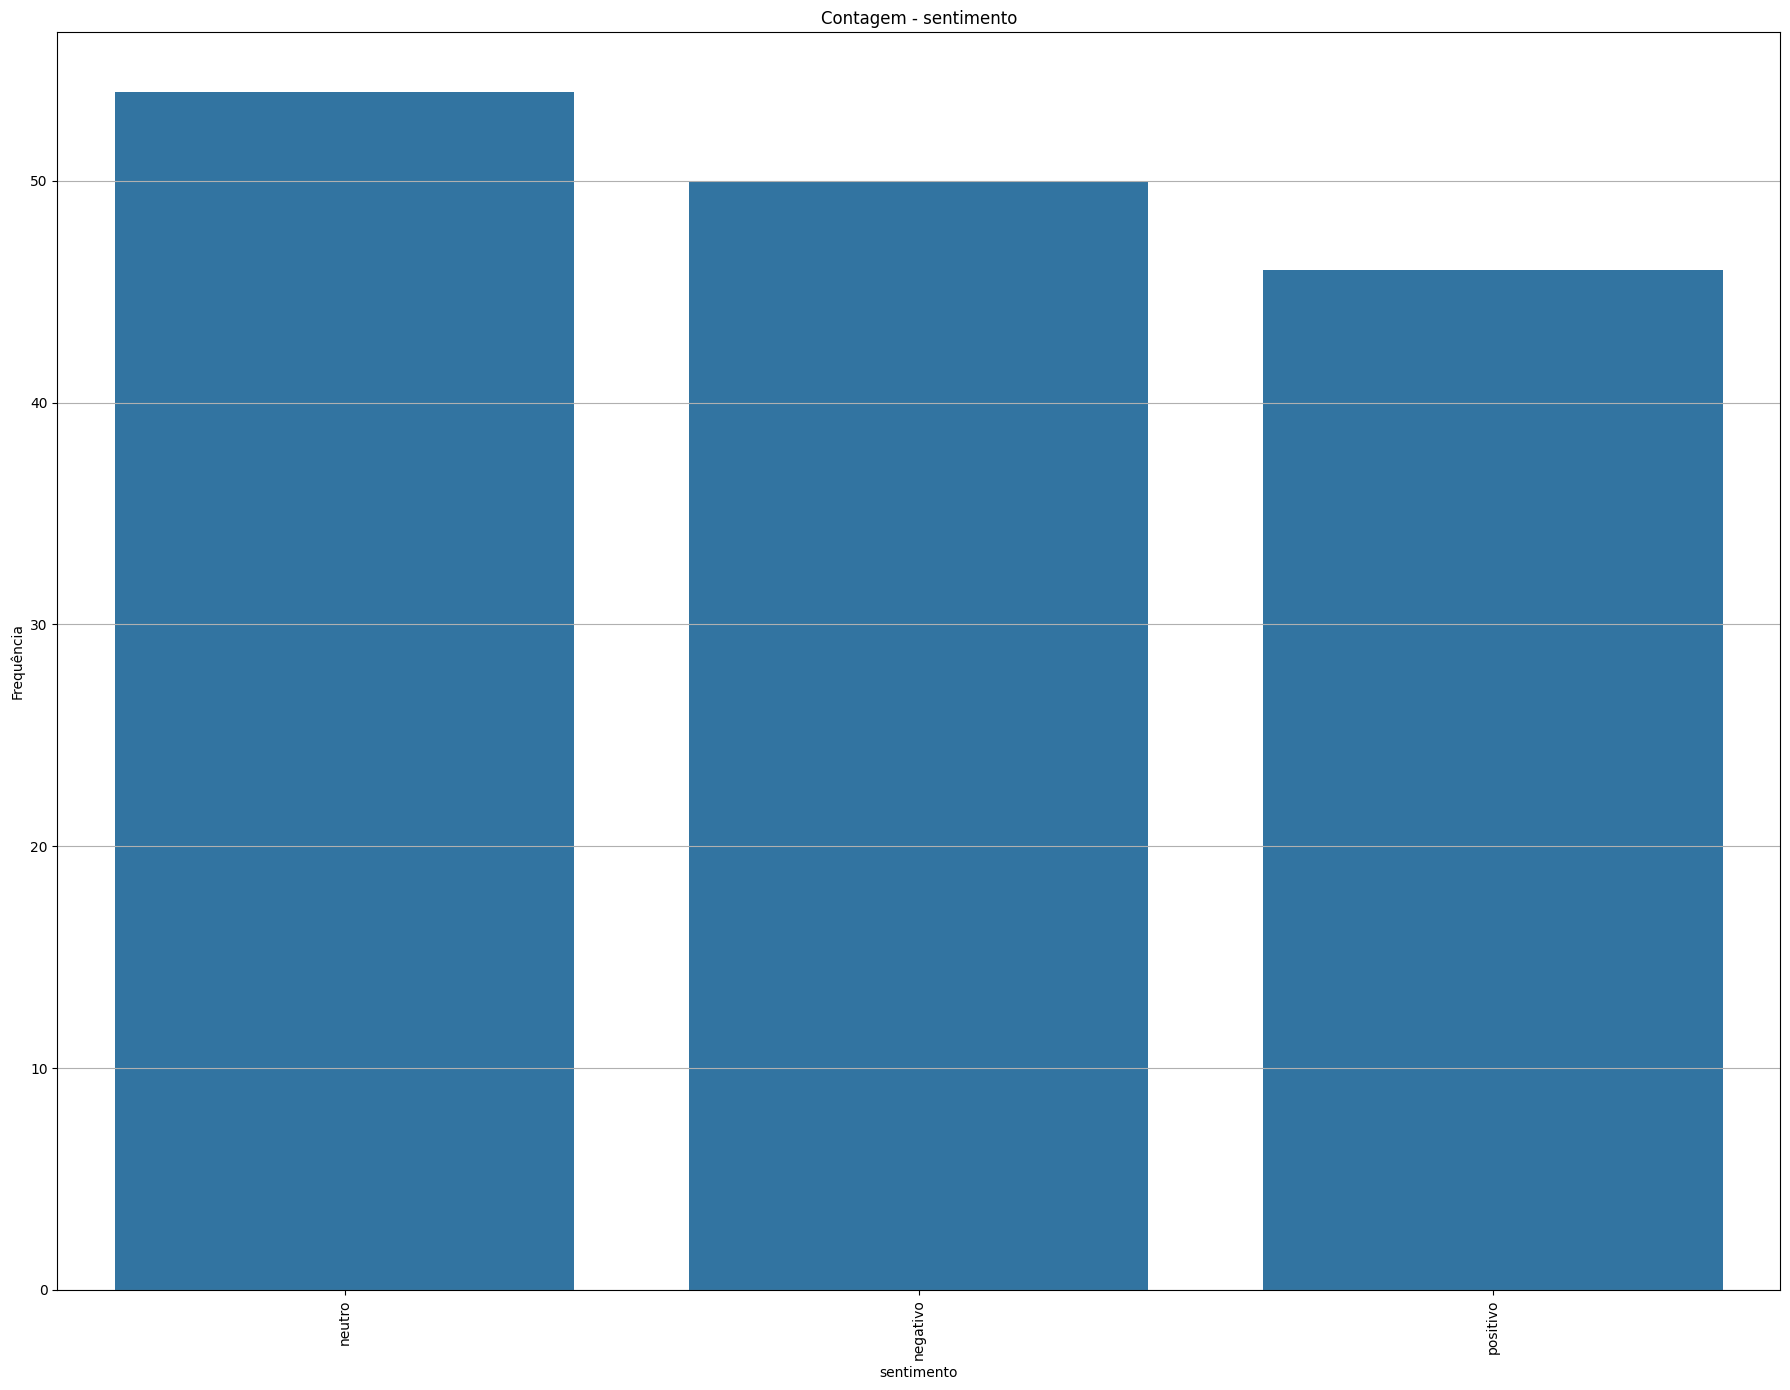

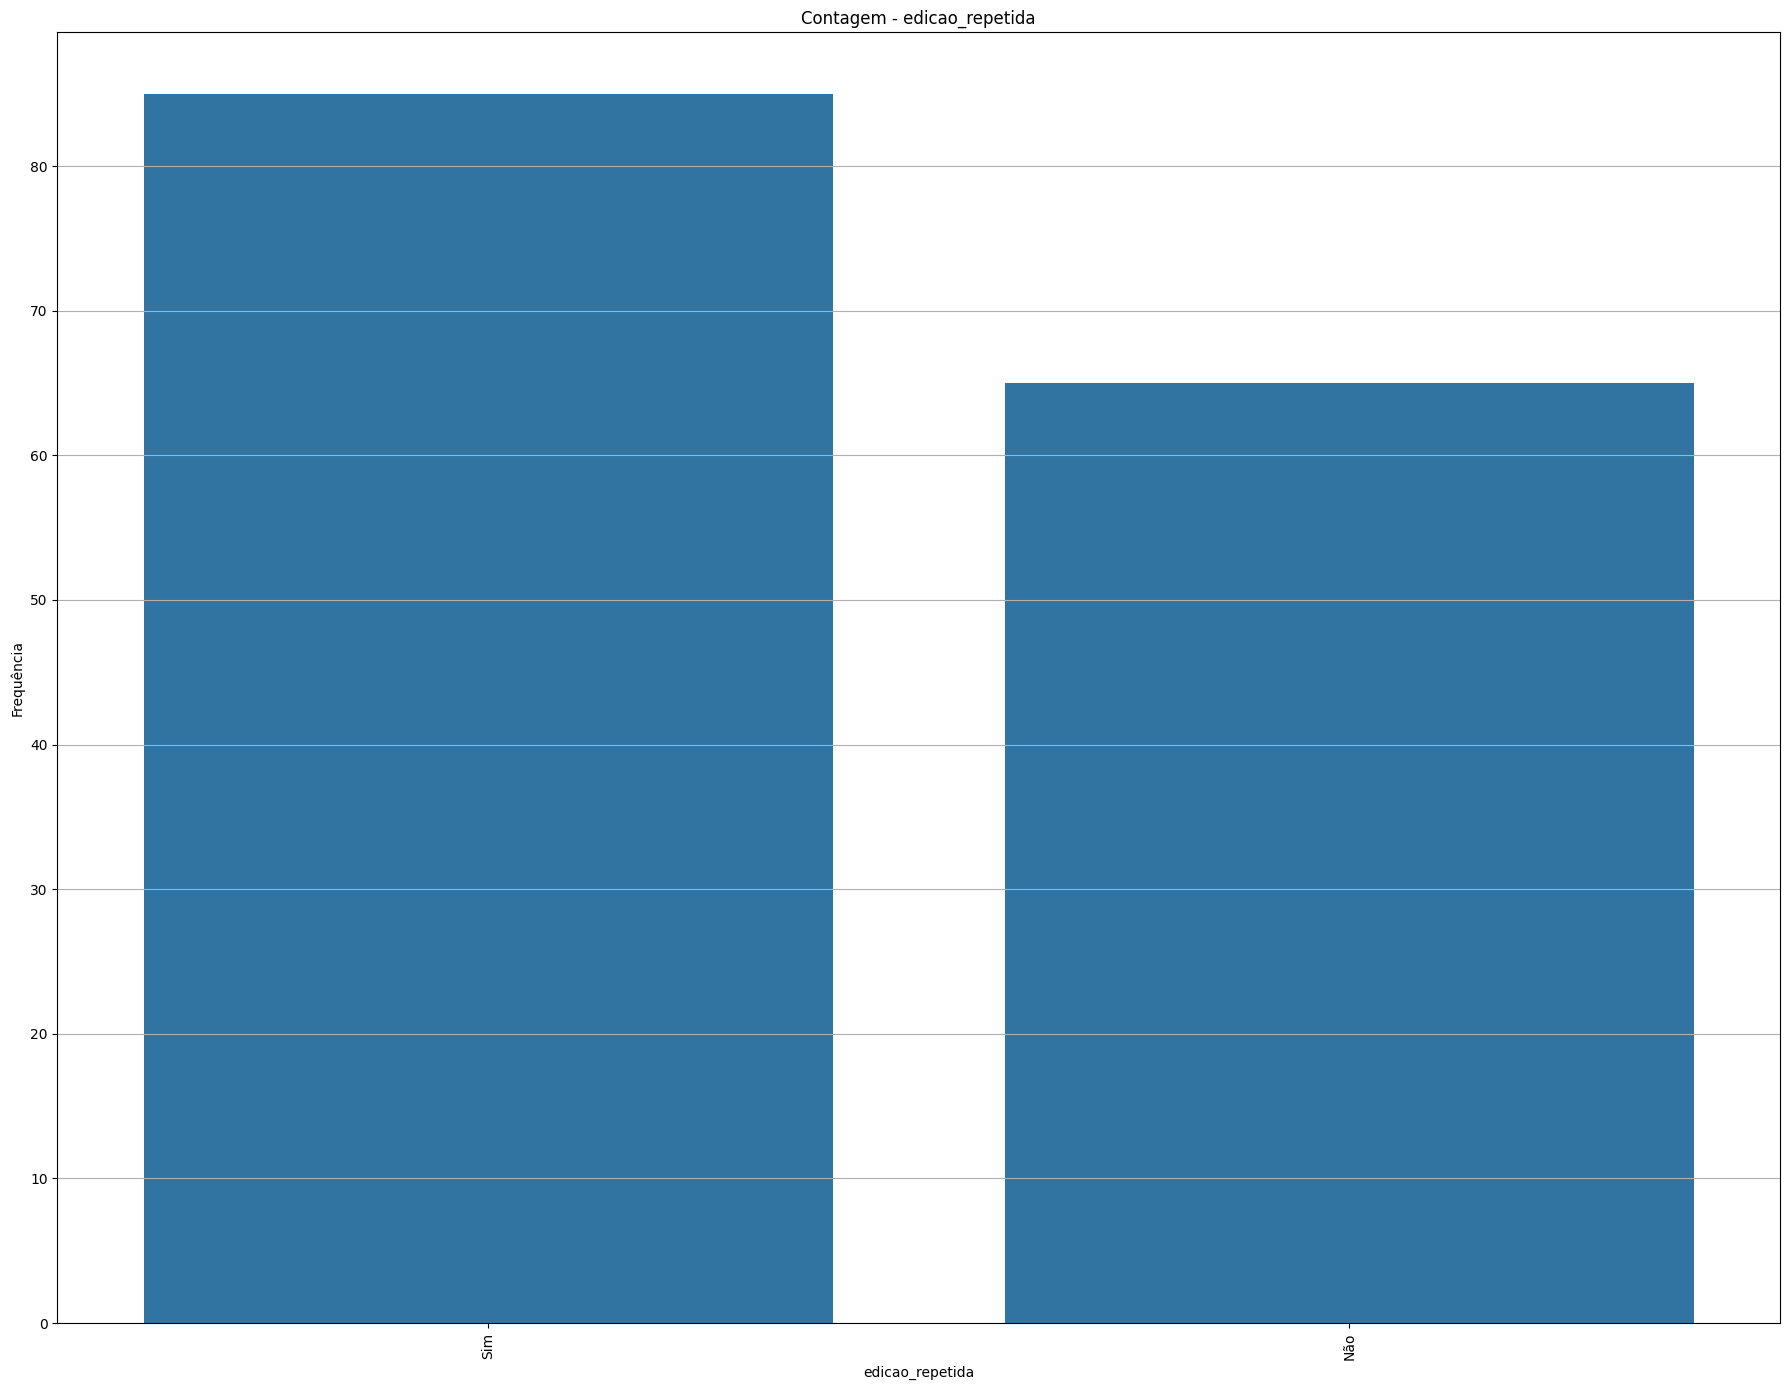

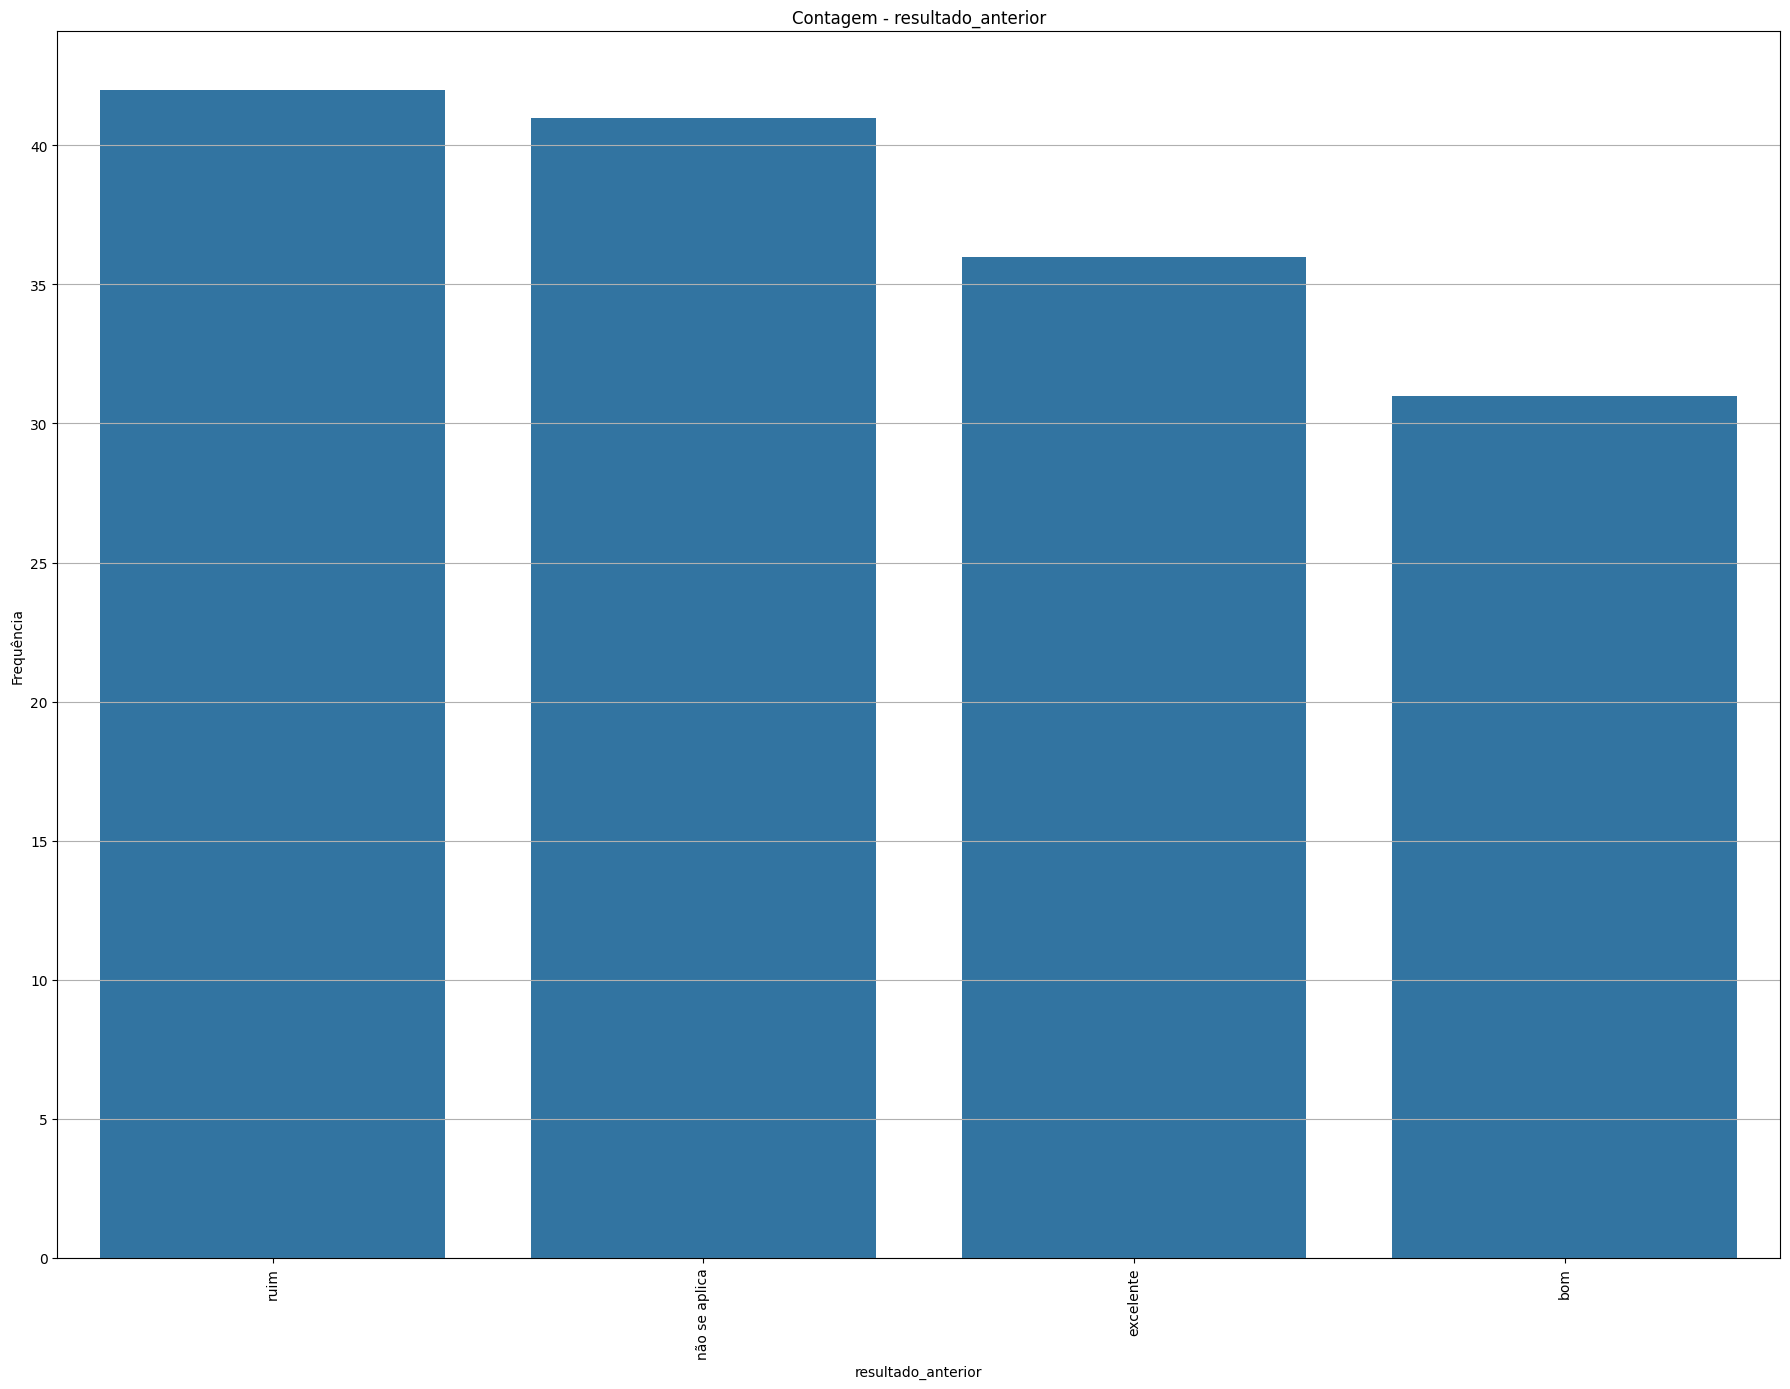

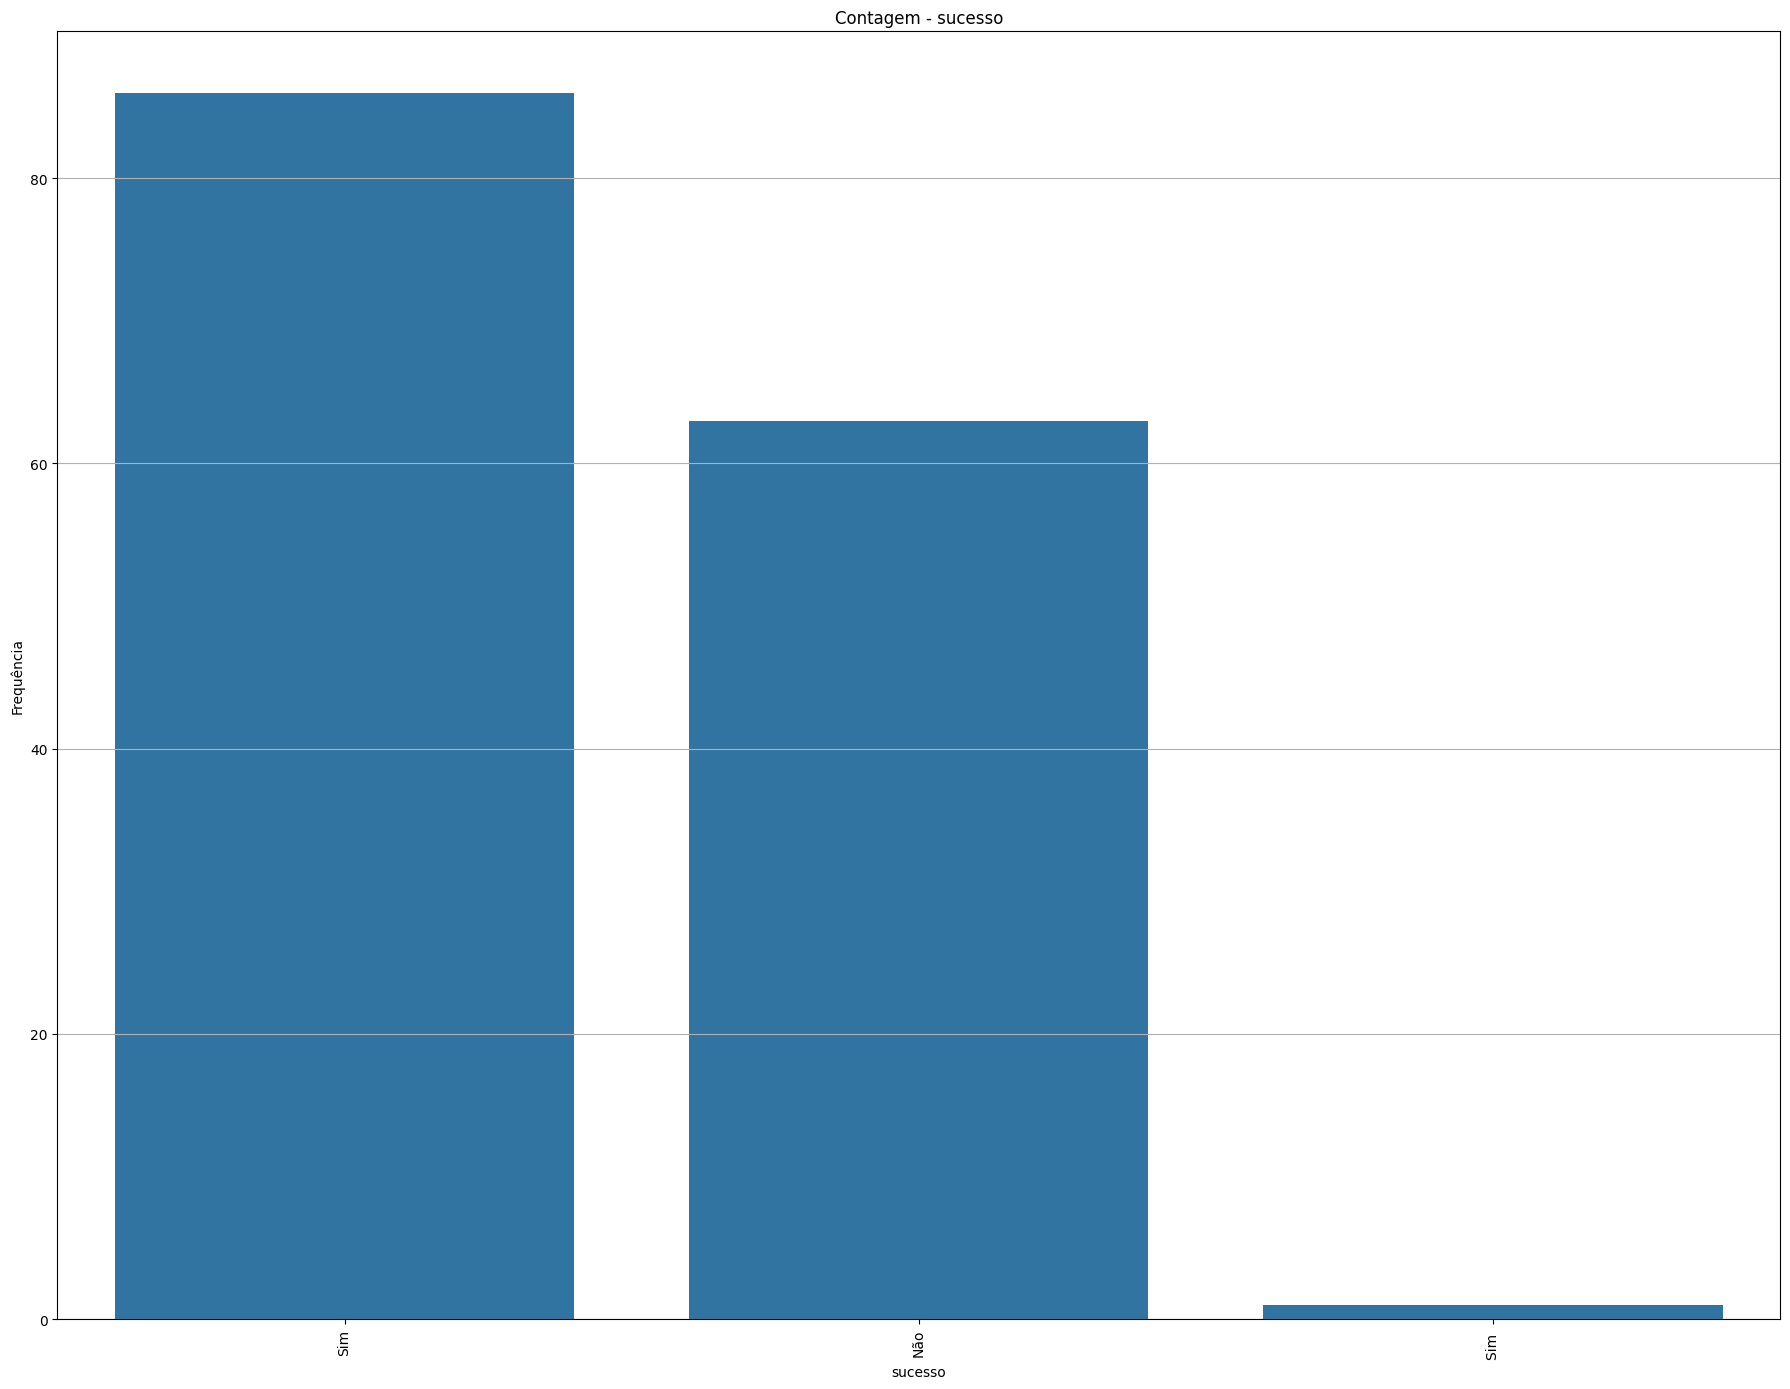

In [10]:
# Plotar contagem para variáveis categóricas
for col in cat_cols:
    plt.figure(figsize=(18, 14))
    sns.countplot(data=df_mkt, x=col, order=df_mkt[col].value_counts().index)
    plt.title(f'Contagem - {col}')
    plt.xlabel(col)
    plt.ylabel('Frequência')
    plt.xticks(rotation=90)
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()


In [11]:
df_mkt.head()

,projeto,produto,tipo,tema,clima,investimento,alcance,engajamento,sentimento,edicao_repetida,resultado_anterior,inovacao,sucesso
0,Carnaval 2024,CARNA2024,Evento,Festivo,ensolarado,40000.0,15000.0,20000.000000,neutro,Sim,bom,2.0,Sim
1,Carnaval 2025,CARNA2025,Evento,Festivo,nublado,20000.0,30000.0,100000.000000,positivo,Sim,ruim,2.0,Não
2,Destino SC Verão 2025,DESTI2025,Turístico,Turismo,nublado,50000.0,20000.0,11097.959491,positivo,Sim,ruim,3.0,Sim
3,Destino de Inverno 2024,DESINV2024,Turístico,Turismo,frio,15000.0,10000.0,5952.031201,negativo,Sim,não se aplica,3.0,Sim
4,Em evidência,EVIDENCIA,Ativação,Diversidade,chuvoso,20000.0,20000.0,5607.226172,neutro,Sim,excelente,4.0,Sim


In [12]:
print(df_mkt.dtypes)

projeto                object
produto                object
tipo                   object
tema                   object
clima                  object
investimento          float64
alcance               float64
engajamento           float64
sentimento             object
edicao_repetida        object
resultado_anterior     object
inovacao              float64
sucesso                object
dtype: object


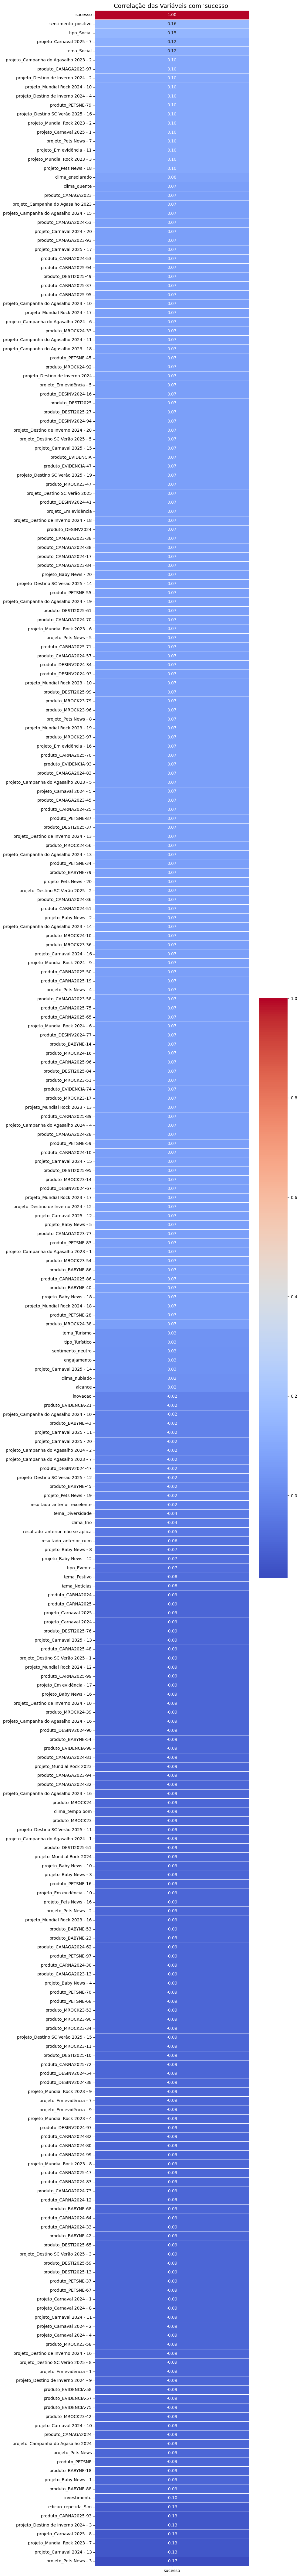

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Copiar os dados
df_temp = df_mkt.copy()

# Transformar variável target 'sucesso' para binário
df_temp['sucesso'] = df_temp['sucesso'].map({'Sim': 1, 'Não': 0})

# Converter todas as variáveis categóricas para dummies (One-Hot Encoding)
df_temp = pd.get_dummies(df_temp, drop_first=True)

# Garantir que não haja NaNs (substituir por 0)
df_temp = df_temp.fillna(0)

# Garantir que tudo seja numérico (float ou int)
df_temp = df_temp.astype(float)

# Calcular correlação
corr_matrix = df_temp.corr()

# Filtrar correlação apenas com o target 'sucesso'
target_corr = corr_matrix[['sucesso']].sort_values(by='sucesso', ascending=False)

# Plotar heatmap com foco na correlação com o target
plt.figure(figsize=(10, len(target_corr) * 0.3))
sns.heatmap(target_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlação das Variáveis com 'sucesso'", fontsize=14)
plt.tight_layout()
plt.show()


In [14]:
df_temp.head()

,investimento,alcance,engajamento,inovacao,sucesso,projeto_Baby News - 1,projeto_Baby News - 10,projeto_Baby News - 12,projeto_Baby News - 16,projeto_Baby News - 18,...,clima_frio,clima_nublado,clima_quente,clima_tempo bom,sentimento_neutro,sentimento_positivo,edicao_repetida_Sim,resultado_anterior_excelente,resultado_anterior_não se aplica,resultado_anterior_ruim
0,40000.0,15000.0,20000.000000,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,20000.0,30000.0,100000.000000,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
2,50000.0,20000.0,11097.959491,3.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
3,15000.0,10000.0,5952.031201,3.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,20000.0,20000.0,5607.226172,4.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0


In [15]:
print(df_temp.dtypes)

investimento                        float64
alcance                             float64
engajamento                         float64
inovacao                            float64
sucesso                             float64
                                     ...   
sentimento_positivo                 float64
edicao_repetida_Sim                 float64
resultado_anterior_excelente        float64
resultado_anterior_não se aplica    float64
resultado_anterior_ruim             float64
Length: 283, dtype: object


In [16]:
df_temp.shape

(150, 283)

#### Separar os dados

In [17]:
# Separar features e target
X = df_temp.drop(columns='sucesso')
y = df_temp['sucesso']

In [18]:
# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#### Treinar modelo XGBoost

In [19]:
# Criar e treinar o modelo
model = XGBClassifier(random_state=42)
model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [20]:
# Avaliar
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         0.0       0.41      0.39      0.40        18
         1.0       0.61      0.63      0.62        27

    accuracy                           0.53        45
   macro avg       0.51      0.51      0.51        45
weighted avg       0.53      0.53      0.53        45



Classe 1 está sendo melhor reconhecida
- Recall = 0.63: o modelo acerta 63% dos positivos reais.
- Precision = 0.61: dos que ele prevê como positivos, 61% são de fato verdadeiros.
Isso sugere que a classe 1 (sucesso = 1) está sendo melhor aprendida pelo modelo.

Acurácia próxima de aleatória (53%)
- Com duas classes, uma acurácia de ~50% indica que o modelo está quase "chutando".
- Porém, como o recall da classe 1 está acima de 0.6, há algum aprendizado acontecendo.

In [29]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from xgboost import XGBClassifier

# Modelo
model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# K-Fold estratificado
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Avaliação com F1-macro
scores = cross_val_score(model, X, y, cv=cv, scoring='f1_macro')

print(f"F1 macro por fold: {scores}")
print(f"Média do F1 macro: {scores.mean():.4f}")

c:\Users\User\Projeto Marketing\mkt\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:16:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\User\Projeto Marketing\mkt\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:16:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\User\Projeto Marketing\mkt\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:16:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\User\Projeto Marketing\mkt\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:16:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_labe

F1 macro por fold: [0.54171563 0.51388889 0.6827262  0.52488688 0.432703  ]
Média do F1 macro: 0.5392


Média 0.5392 indica que o modelo não está generalizando muito bem, mas também não está completamente aleatório.
Pode estar sofrendo com:
- Poucos dados
-Muitas features (283 colunas)
- Dados desbalanceados

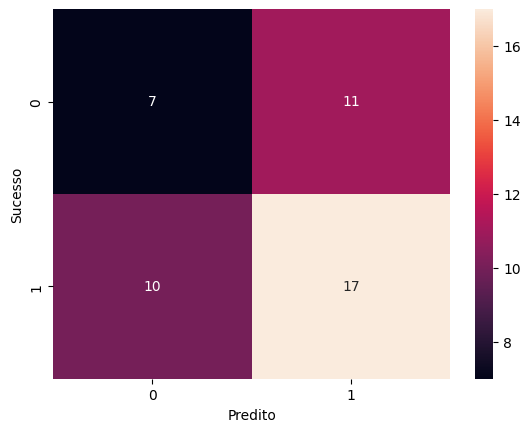

In [30]:
# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predito')
plt.ylabel('Sucesso')
plt.show()

Classe 0 está com desempenho fraco
- Apenas 7 acertos (TP) de um total de 18.
- O modelo comete mais erros (11 falsos positivos) do que acertos.
Precision e recall abaixo de 0.4, o que indica baixa confiabilidade ao prever “insucesso”.

In [23]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia: {accuracy}")

Acurácia: 0.5333333333333333


AUC: 0.537037037037037


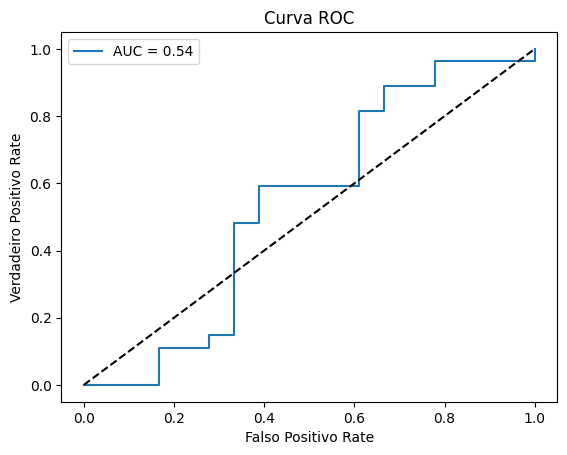

In [24]:
# ROC Curve e AUC (Area Under the Curve)
y_prob = model.predict_proba(X_test)[:, 1]  # probabilidades para classe 1
auc = roc_auc_score(y_test, y_prob)
print(f"AUC: {auc}")

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Falso Positivo Rate')
plt.ylabel('Verdadeiro Positivo Rate')
plt.title('Curva ROC')
plt.legend()
plt.show()


Eixo X (Falso Positivo Rate - FPR): Quanto o modelo erra dizendo que algo é positivo quando não é.

Eixo Y (Verdadeiro Positivo Rate - TPR / recall): Quanto o modelo acerta dizendo que algo é positivo quando realmente é.

Linha tracejada diagonal: É o desempenho de um modelo aleatório (AUC = 0.5).

Um AUC de 0.54 indica que seu modelo mal consegue distinguir entre as classes, estando muito próximo de um modelo aleatório. Isso está em linha com o F1 macro (~0.53) e reforça a necessidade de reduzir a dimensionalidade, reavaliar as variáveis e possivelmente testar outras abordagens de modelagem.

In [ ]:
# Mede a qualidade das probabilidades previstas.from sklearn.metrics import log_loss
loss = log_loss(y_test, y_prob)
print(f"Log Loss: {loss}")

Log Loss: 0.987713187473005


In [ ]:
# Modelo
model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# K-Fold estratificado
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Avaliação com F1-macro
scores = cross_val_score(model, X, y, cv=cv, scoring='f1_macro')

print(f"F1 macro por fold: {scores}")
print(f"Média do F1 macro: {scores.mean():.4f}")


c:\Users\User\Projeto Marketing\mkt\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:14:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\User\Projeto Marketing\mkt\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:14:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\User\Projeto Marketing\mkt\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:14:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\User\Projeto Marketing\mkt\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:14:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_labe

F1 macro por fold: [0.54171563 0.51388889 0.6827262  0.52488688 0.432703  ]
Média do F1 macro: 0.5392


c:\Users\User\Projeto Marketing\mkt\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:15:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


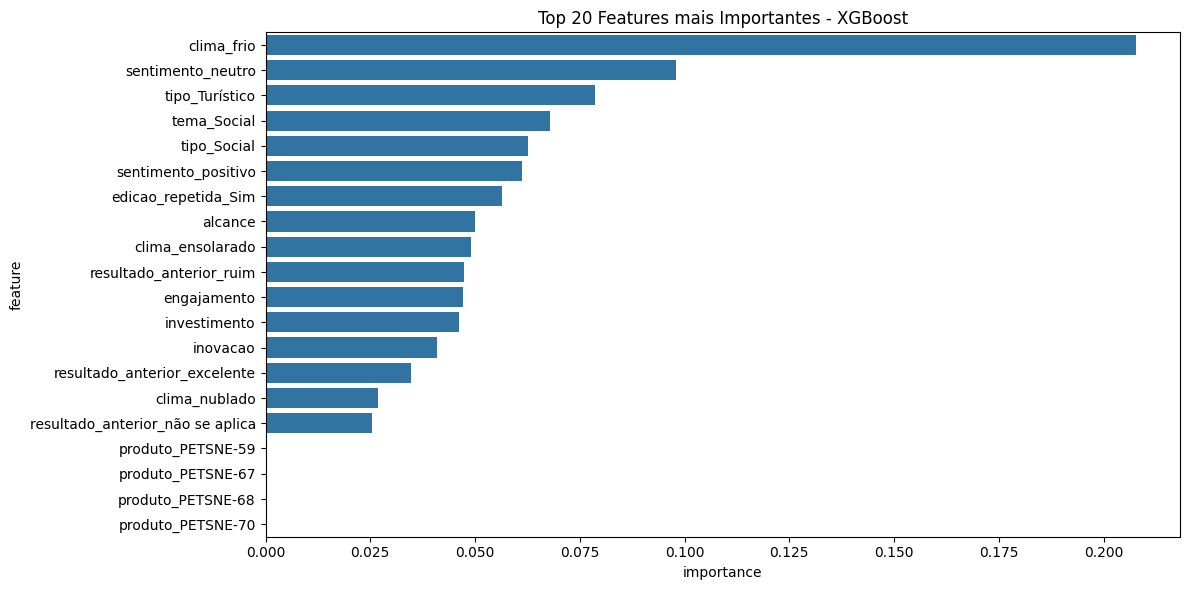

In [28]:
# Treinar modelo com todos os dados
model.fit(X, y)

# Obter importâncias
importances = model.feature_importances_
feature_names = X.columns

# Visualizar top 20
import pandas as pd
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Plotar
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.barplot(data=importance_df.head(20), x='importance', y='feature')
plt.title('Top 20 Features mais Importantes - XGBoost')
plt.tight_layout()
plt.show()
